<h1 align=center><font size = 5>Linear Regression </h1 >

### References:
    [1] Redes Neuronales y Sistemas Borrosos. 3ª Edición (Spanish Edition). Bonifacio Martín del Brío, Alfredo Sanz Molina. RA-MA S.A. Editorial y Publicaciones, 28 nov. 
    
In this notebook we used the next Python libraries:

In [1]:
import cmath
import numpy as np
import torch as th
import tensorflow as tf

import matplotlib.pyplot as plt

## Introduction
Linear regression models or linear classifiers are models used to correlate/transform/map an input into an output. This transformation gets done through a linear equation of the form:

$Linear \ equation :y=mx+b$

In Machine Learning terminology, the slope 'm' is designated with the letter 'w' of weight. Then we have

$Linear \ equation :y=wx+b$

In python we can write this linear equation in a function like this:

In [2]:
# defining the linear equation
def l_eq(x):
    w, b = 2,1
    y = (w*x) + b
    return y

# example using one input
x = 1
print('model output to one input:', l_eq(x))
# example using multiple inputs
x = np.array([1,2])
print('model output to multiple inputs:', l_eq(x))

model output to one input: 3
model output to multiple inputs: [3 5]


In the beginning the model don't know how to do this input-output mapping. The idea is that we can train the model so it can learn the correlation. Internally, what this training means is finding the best parameter 'w'. In the next example we can observe this better

### Example 1

In the next example, we trained a model that learnt how to transform an input vector 'x' into a vector 'y'. We assumed in this example that initialy, w = 10 and b=0:

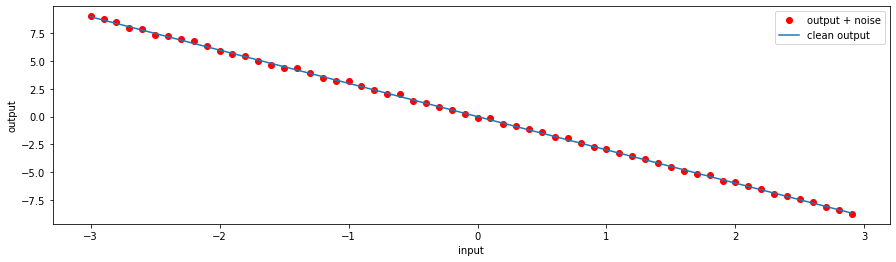

In [3]:
# Generating the input
X = (np.arange(-3,3,0.1)) # This should be row vector, but because of the next visualization is leave it like this
# Generating the output
f = -3*X
# Adding noise
Y = f+0.1*np.random.randn(len(X))

plt.figure(figsize=(15,4))
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.xlabel('input')
plt.ylabel('output')
plt.legend();

If we give our input vector 'X' to the model **before training**, we can show how in the beginning the model does not know how to map the input 'X' to our 'Y' output.

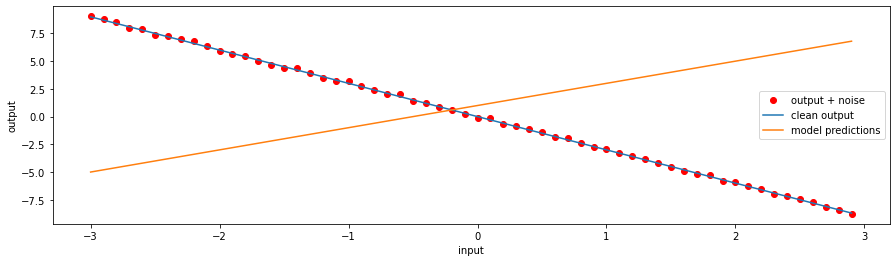

In [4]:
# Appliying the input to our model
Y_pred = l_eq(X)
# Model visualizations
plt.figure(figsize=(15,4))
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.plot(X,Y_pred, label='model predictions')
plt.xlabel('input')
plt.ylabel('output')
plt.legend();

## Model Learning Process
As mentioned before, the way that our model will learn is by finding the parameter 'w' that best correlate the input-output pairs as a whole. This method consist in propose an **error function or cost** that measure the current model performance and try to minimize this function. This allows the model to adjust its parameters ('w' in this case) iteratively through an **optimization function**.

In summary, to achieve this learning process, we need to define: 

1. An **error function** to measure the model performance. This error is usually the well known as Mean Square Error (MSE). But there are others such as the Root Mean Square Error (RMSE):

$$E = MSE =\frac{1}{n} * \sum_{i=1}^n (y_i - ypred_i)^2$$

Where

$$y_i = target ... ypred_i = w X+b$$

2. An **optimization rule** to update the model parameters until its output tends to be as desired. One optimization rule that illustrate the usual way of obtaining learning algorithms is known as the rule of Widrow-Hoff or Least Mean Squares (LMS)[1]:

$$W_{(t+1)} = W_t- lr * \delta E_{(W)}$$

Where

$$\delta E_{(W)} = \delta \frac{E_{w}}{\delta w} = -(1/2) * 2 \sum_{i=1}^n (y_i - ypred) \frac {dypred_i}{dw} $$


To easily compute the partial derivatives with respect to the weights 'w', which in this case would be with respect to the error E(W), we will use a torch tensor from the library PyTorch. We need to take into account that as only 'w' and 'b' are the parameter that needs to be derivate, it is the only one that needs to be a pytorch tensor with <code>requires_grad=True</code>. We will also need to make the linear equation and the error functions to be compatible with torch tensors since these also contain 'w':

In [5]:
# Defining train parameter in PyTorch
w, b = th.tensor(-10.0, requires_grad=True), th.tensor(0.0, requires_grad=True)

# defining the linear equation (the forward function)
def l_eq(x):
    y = (w*th.tensor(x)) + b
    return y

# MSE error function 
def MSE_err_f(y_pre, y):
    err = th.mean((th.tensor(y)-y_pre)**2)
    return err

# LMS Optimizer
def LMS_optimizer(w,lr,d_e):
    wt = w - lr * d_e
    return wt

Now, lets define the initial paramenters *learning rate* $lr$ and the number of *epochs* our model will take to train

In [6]:
# Initial parameters
epochs = 4
lr = 0.1
# Variables initialization
ERR = []
YP = []
W = []

for epoch in range(epochs):
    # 1. First make a prediction
    y_pred = l_eq(X)
    YP.append(y_pred)
    # 2. get the model error
    err = MSE_err_f(y_pred,Y)
    err.backward()
    # 3. Model update
    w.data = LMS_optimizer(w.data, lr, w.grad.data)
    w.grad.data.zero_()
    
    W.append(w.data)
    ERR.append(err.detach().numpy())

Text(0, 0.5, 'Err')

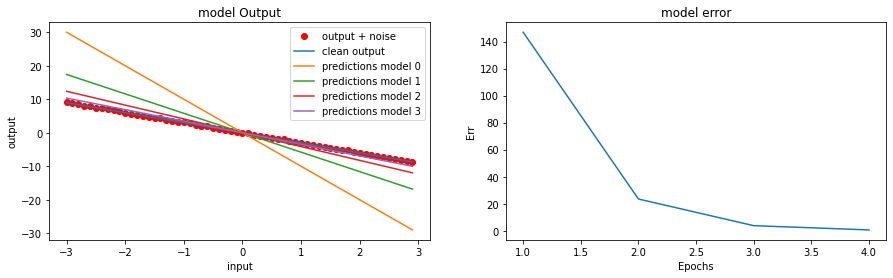

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
for i in range(epochs):
    plt.plot(X,YP[i].detach().numpy(), label='predictions model %s' %i);
plt.title('model Output')
plt.xlabel('input')
plt.ylabel('output')
plt.legend();
plt.subplot(1,2,2)
plt.plot(np.arange(1,epochs+1, 1), ERR)
plt.title('model error')
plt.xlabel('Epochs')
plt.ylabel('Err')

## Conclusion
When the learning rate equal 1 the model converge quickly in the first and second epoch. Then the model overtrains itself. Perhaps if we starts with a learning rate equal 1, then we decreased in a slowly using some sort of decreasing functions every iteration (e.g. $R_{(t)} = R_0 + (R_f - R_0) \frac{t}{t_R})$.

### Example 2 - Fitting a Line - Using Pytorch

In the next example, we implement linear regression using Pytorch. This requires to write all variables as **torch tensors**. The functions will be re-write just to show the simple way they need to look. The only thing to consider is that any operation inside a function need to be carry out between tensor variables.

In [8]:
# Generating the input
X = th.arange(-3,3,0.1)#.view(-1,1) # This should be row vector, but because of the next visualization is leave it
# Remember making X a row vector
# X = X.view(-1,1)like this
# Generating the output
f = -3*X
# Adding noise
Y = f + 0.1 * np.random.randn(len(X))
# Initializing variables to derivate
w = th.tensor(-10.0, requires_grad = True)
b = th.tensor(0.0, requires_grad = True)

# defining the linear equation
def l_eq(x):
    y = (w*x) + b
    return y

# MSE error function 
def MSE_err_f(y_pre, y):
    err = th.mean((y_pre-y)**2)
    return err

# LMS Optimizer
def LMS_optimizer(w,lr,d_e):
    wt = w - lr * d_e
    return wt

Again, if we give our input vector 'X' to the model **before training**, we can show how in the beginning the model does not know how to map the input 'X' to our 'Y' output.

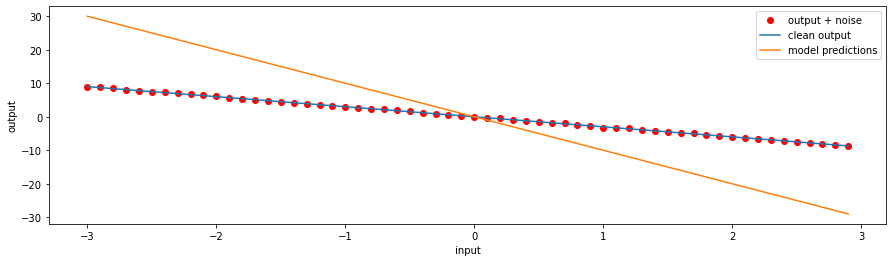

In [9]:
# Appliying the input to our model
Y_pred = l_eq(X)
# Model visualizations
plt.figure(figsize=(15,4))
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.plot(X,Y_pred.detach().numpy(), label='model predictions')
plt.xlabel('input')
plt.ylabel('output')
plt.legend();

## Model Training
Now, lets pass our input 'x' to update our model parameters in 4 iterations or **epochs**. Our learning rate can be 0.1

In [10]:
# Defining initial parameters
epochs = 4
lr = 0.1
# ERR to store the error in each iteration
ERR = []
# Y_PRED to store the model output mapping in each iteration
Y_PRED = []

# training loop
for epoch in range(epochs):
    # Appliying prediction
    y_pred = l_eq(X)
    # appliying error
    err = MSE_err_f(y_pred,Y)
    err.backward()
    # Appliying learning rule
    w.data = LMS_optimizer(w.data,lr,w.grad.data)
    w.grad.data.zero_()
    # adding values
    ERR.append(err.detach().numpy()) 
    Y_PRED.append(y_pred)

After training the model, we can check how the model error decended from a high value to a value close to zero

Text(0, 0.5, 'Error')

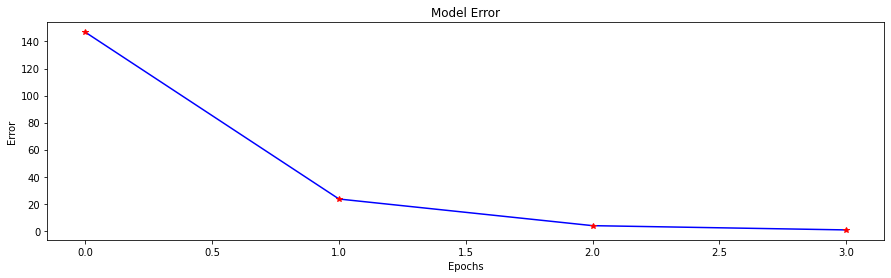

In [11]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(epochs),ERR, 'b')
plt.plot(np.arange(epochs),ERR, '*r')
plt.title('Model Error')
plt.xlabel('Epochs')
plt.ylabel('Error')

Also how the model fitted the line each epoch at the time

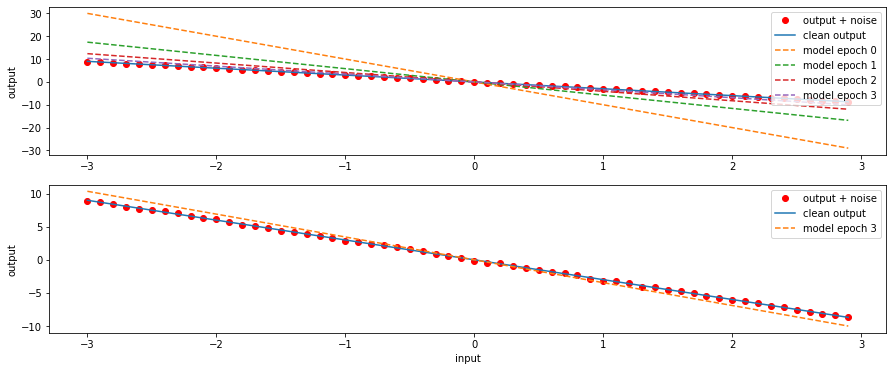

In [12]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
for i, lines in enumerate(Y_PRED):
    plt.plot(X,lines.detach().numpy(), '--', label='model epoch '+ str(i))
plt.ylabel('output')
plt.legend();

plt.subplot(2,1,2)
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.plot(X,lines.detach().numpy(), '--', label='model epoch '+ str(i))
plt.xlabel('input')
plt.ylabel('output')
plt.legend();

### The Pytorch Way
In the next cells we used the pytorch functions available to create the same results. For tthat we first needed to create a module that contain the model structure. We defined the model input and output size:

In [39]:
# Creating module structure
class LR(th.nn.Module):
    def __init__(self, in_size, out_size):
        # Initialization
        super(LR, self).__init__()
        #th.nn.Module.__init__(self)
        # Creating the Linear object - model Linear function
        self.linear = th.nn.Linear(in_size, out_size)
        
    def forward(self, x):
        y = self.linear(x)
        return y
    
# Now we can call the class LR to create our model, specifying our inputs and outputs
model = LR(1,1)
# exploring parameters
print(list(model.parameters()))

# creating an optimizer
optimizer = th.optim.Adam(model.parameters(), lr = 0.1)
# creating error function
err = th.nn.MSELoss()

[Parameter containing:
tensor([[-0.6542]], requires_grad=True), Parameter containing:
tensor([0.6101], requires_grad=True)]


In the printed lines above, the first value corresponds to our 'w' and the second to the parameter 'b'. 
Next we will create check that our model, before training, does not know the input-output correlation

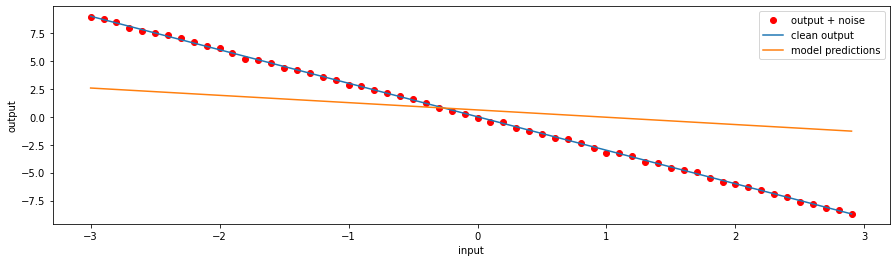

In [40]:
# here we need to transform X in a raw vector
X = X.view(-1,1)
y_pred = model(X).detach().numpy()

# Model visualizations
plt.figure(figsize=(15,4))
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.plot(X,y_pred, label='model predictions')
plt.xlabel('input')
plt.ylabel('output')
plt.legend();

Now, lets train our new model the Pytorch Way

In [41]:
w = th.tensor(-10.0, requires_grad=True)
# Initial parameters
epochs = 4
lr = 0.1
# Variables initialization
ERR = []
YP = []
W = []

for epoch in range(epochs):
    # 1. model predictions
    y_pred = model(X)
    YP.append(y_pred)
    # 2. error calculation
    err = MSE_err_f(y_pred,Y)
    # 3. parameter upgrade
    optimizer.zero_grad()
    err.backward()
    optimizer.step()
    
    
    W.append(w.data)
    ERR.append(err.detach().numpy())

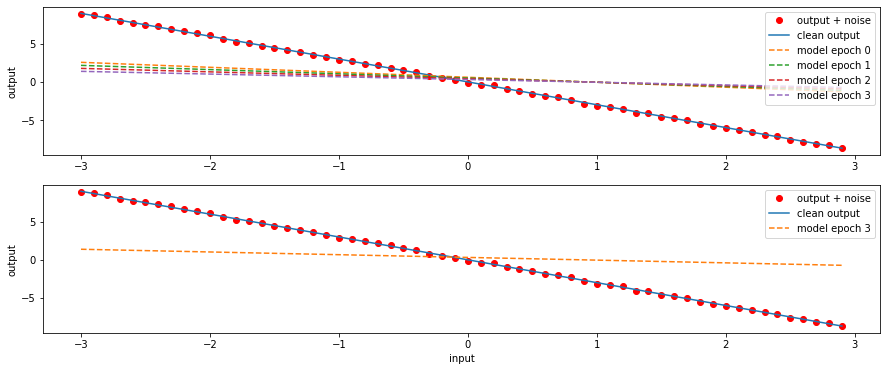

In [42]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
for i, lines in enumerate(YP):
    plt.plot(X,lines.detach().numpy(), '--', label='model epoch '+ str(i))
plt.ylabel('output')
plt.legend();

plt.subplot(2,1,2)
plt.plot(X, Y, 'ro', label='output + noise');
plt.plot(X, f, label='clean output');
plt.plot(X,lines.detach().numpy(), '--', label='model epoch '+ str(i))
plt.xlabel('input')
plt.ylabel('output')
plt.legend();